# Predicting Malaria in Nigeria with Machine Learning

## Machine Learning Project for Abt Associates through the Univeristy of Michigan

### Contributors: Brian Liggio, Jessica Sickles, Prashant Toteja, Keely Meyers

The overarching goal for this project was to create a model that would predict malaria outbreaks in Nigeria.  The data for this project consists of various spatial images from open data sources (Malaria Atlas Project and Terraclip).  These images were manually cropped, scaled, and transformed in order to be compatible with the machine learning model.  The data analysis portion of the project included preliminary data cleaning, transforming image data to a Pandas dataframe, and creating a basic prediction visualization based on various machine learning techniques.  These steps produced initial image based on the collected spatial data. (add more as the model becomes more robust and interactive features are added to the map)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import numpy
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.formula.api as smf
import statsmodels.api as sm


#from gridsearch import get_results
import time
import itertools
from sklearn.linear_model import Ridge
%pylab inline

/Users/prashanttoteja/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/prashanttoteja/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/Users/prashanttoteja/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


##### Here we define three different functions:

**feature_to_array**: The input of the function is a raster file with dimentions (n pixels,m pixels), and the output is going to be an array of dimmensions (m*n,1). *Each pixel is going to have a unique identifier (index in the array). This index follows the formula *(i*n)+j where (i,j) is the position of the pixel in the image and n is the width of the image.

**rgb2gray**: Converts an RGB image or colormap to grayscale.

**read_pictures**: Used to read in the images.

In [2]:
def feature_to_array(file_n): #Input is raster file with dimensions (n pixels, m pixels) and the output is an array of dimensions (m*n,1) -- Each pixel has a unique identifier
    im = mpimg.imread(file_n)  
    im_greyscale = rgb2gray(im)   
    imarray = numpy.array(im_greyscale)
    feature=[i for a in imarray for i in a]
    return feature

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])   #Greyscale value dimensions

def read_pictures(filename):   #Function to read the images in
    file_name=filename
    im = mpimg.imread(file_name)  
    im_greyscale = rgb2gray(im)

## Reading the Data

We insert each image into our feature_to_array function and assign each output to a variable respresenting the data within the respective image. We chose to use "endemicity" as our Y variable. In our regression model, we define endemicity as the predicted percentage of malaria prevalence in a given area.  We have chosen 12 predictor variables to include in our model.

##### Predcitor Variables:

resistance: Mean estimates of sickle cell haemoglobin allele frequency

fever_proportion: Malaria-positive fevers as a proportion of all-cause fevers in 2015 in Nigeria

mosquito_proportion: The spatial distribution of Plasmodium falciparum malaria endemicity in 2015 in Nigeria

temp_suitability: The annual temperature suitability index for Plasmodium falciparum transmission which reflects the impact of daily temperature on vector survival 

proximity_to_urban: Modeled accessibility to high-density urban centers for 2015 in Nigeria (measured by travel time)

urban: Modeled distribution of urban centers 

annual_mean_temp: Annual mean temperature 

cropland: Distribution of natural vegetation 

precipitation: Precipitation seasonality

vegetation: Areas of primary vegetation 

annual_temp_range: Annual temperature range

water_bodies: Locations of all water bodies 

In [3]:
file_name = 'Malaria_resistance_sickle_cell.png'
resistance = feature_to_array(file_name) 

file_name ='PfMalaria_fever_porportion_to_all_illness_2015.png'
fever_proportion = feature_to_array(file_name) 

file_name = 'PfPR_2015_NGA_proportion_2_10.png'
mosquito_proportion = feature_to_array(file_name) 

file_name = 'temp_suitability.png'
temp_suitability = feature_to_array(file_name) 

file_name = 'Travel_time_to_urban_centers.png'
proximity_to_urban = feature_to_array(file_name) 

file_name = 'Urban2012.png'
urban = feature_to_array(file_name) 

file_name = 'USE_annual_mean_temp.png'
annual_mean_temp = feature_to_array(file_name) 

file_name = 'USE_cropland.png'
cropland = feature_to_array(file_name)

file_name = 'USE_prec_seasonality_013.png'
precipitation = feature_to_array(file_name)

file_name = 'USE_primary_vegetation.png'
vegetation = feature_to_array(file_name)

file_name = 'USE_temp_annual_range_2015.png'
annual_temp_range = feature_to_array(file_name)

file_name = 'Water_bodies.png'
water_bodies = feature_to_array(file_name)

file_name = 'PF_parasite_endemicity.png'    #Y variable
endemicity = feature_to_array(file_name) 

file_name = 'Land_coverage.png'     #In or outside Nigeria
land_coverage = feature_to_array(file_name) 

file_name='Primary Vegetated Areas_2000.png'

im = mpimg.imread(file_name)  
im_greyscale = rgb2gray(im)   
imarray = numpy.array(im_greyscale)
feature=[a for a in imarray]  #iterable one level out
feature

In [4]:
data = pd.DataFrame([resistance, fever_proportion, mosquito_proportion, temp_suitability, proximity_to_urban, urban, annual_mean_temp, cropland, precipitation, vegetation, annual_temp_range, water_bodies, endemicity]).T

data.columns = ['Resistance','Fever_prop','Mosquito_prop', 'Temp_suitability','Proximity_to_urban','Urban','Annual_mean_temp','Cropland','Precipitation', 'Vegetation', 'Annual_temp_range', 'Water_bodies', 'Endemicity']


## Machine Learning - Regressions

In [5]:
## Splitting into X and Y training/testing sets

data = data.dropna()

nn_data = data

X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


## Ordinary Least Squares Regression

The purpose of this linear regression was use the predictor variables to identify areas of high or low malaria risk. The model achieved an R-squared value of over 0.93, indicating that over 93% of the variability in the Y variable (endemicity) was explained by the model.  This indicated a significant and accurate model. The predictons were then mapped from an array back to an image to produce the static output seen below.

In [6]:
model = sm.OLS(Y, X, standardize=False).fit()   #fitting OLS to our data
print(model.summary())
data['Predictions_OLS_1'] = model.predict(X)    #using function to visualize it's fit

                            OLS Regression Results                            
Dep. Variable:             Endemicity   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                 1.489e+05
Date:                Wed, 10 Apr 2019   Prob (F-statistic):               0.00
Time:                        11:44:15   Log-Likelihood:                 61883.
No. Observations:              120432   AIC:                        -1.237e+05
Df Residuals:                  120421   BIC:                        -1.236e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Resistance             0.8268      0

In [7]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)




In [8]:
## Evaluating Model

ols_mod_train = smf.ols('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
#print (roc_auc_score(np.where(ols_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))



AssertionError: 

In [12]:
print (roc_auc_score(np.where(ols_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

NameError: name 'ols_mod_train' is not defined

In [13]:
data['Predictions_OLS_1'].head(10) #View of first 10 predictions as per the model

0    0.96583
1    0.96583
2    0.96583
3    0.96583
4    0.96583
5    0.96583
6    0.96583
7    0.96583
8    0.96583
9    0.96583
Name: Predictions_OLS_1, dtype: float64

In [14]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)


In [15]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.Predictions_OLS_1[M] 
m_l=matrix.tolist()

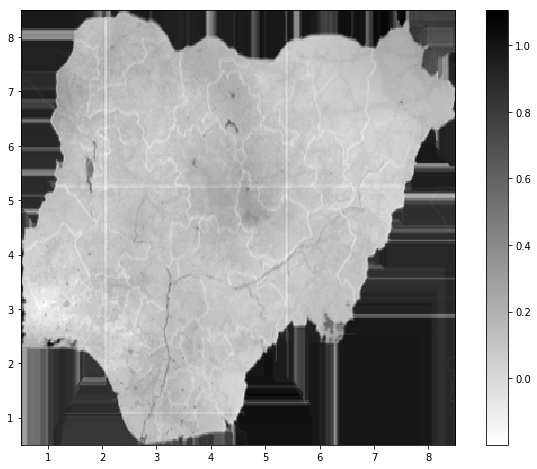

In [16]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('ols.png')

## Random Forest Regressor

The random forest model was implemented from sklearn and was ran with 1000 trees as an arbitrary start.  The model achieved a high fit score of 0.98.  The feature importance was gathered for each variable in the model and was used to create a datafram based on this metric.  This datafram was used to make predictions about areas of high and low risk for malaria in Nigeria, and display those prediction on another static map.

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 10)

In [20]:
rf.fit(X, Y) #fitting random forest model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False)

In [21]:
rf.score(X,Y) #calculating fit score

0.9881314494191785

In [22]:
rf.feature_importances_ #finding what features are most important in the model

array([6.23389820e-02, 1.41801116e-02, 1.54710820e-02, 8.41350762e-01,
       1.93250405e-02, 1.56387130e-04, 5.41726674e-03, 3.51376005e-03,
       1.65173034e-02, 4.96420880e-04, 2.10626132e-02, 1.70270450e-04])

In [23]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances


,importance
Temp_suitability,0.841351
Resistance,0.062339
Annual_temp_range,0.021063
Proximity_to_urban,0.019325
Precipitation,0.016517
Mosquito_prop,0.015471
Fever_prop,0.014180
Annual_mean_temp,0.005417
Cropland,0.003514
Vegetation,0.000496


In [24]:
data['rf_predictions'] = rf.predict(X)

In [25]:
data['rf_predictions'].head(10)

0    0.999998
1    0.999998
2    0.999998
3    0.999998
4    0.999998
5    0.999998
6    0.999998
7    0.999998
8    0.999998
9    0.999998
Name: rf_predictions, dtype: float64

In [26]:
predictions = data['rf_predictions']
errors = abs(predictions - Y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.01


In [27]:
## Calculating mean absolute percentage error (MAPE)

mape = 100 * (errors / Y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), "%")

Accuracy: 94.93 %


In [28]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        #print(M)
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [29]:
matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]= data.rf_predictions[M] 
m_l=matrix.tolist()

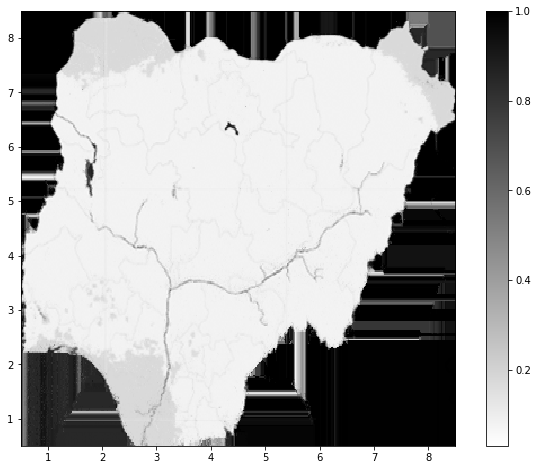

In [30]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(11, 8))
plt.imshow(m_l,  interpolation='nearest', cmap='binary', extent=(0.5,8.5,0.5,8.5))
plt.colorbar()
plt.savefig('rf.png')

## Malaria Treated as a Classification Problem

## Logistic Regression

Another approach that was used was to treat the prediction of malaria risk as a classification problem, in which an "at risk" area is defined as one with a risk greater than 0.5, and a "non-risk" areas is one with a risk less than 0.5.  This model produced an Area Under the Curve AUC score of 0.98, a high score. A perfect model will have an AUC score of 1 while a completely ineffective model will score 0.5.

In [31]:
#data['Endemicity'] = np.where(data['Endemicity'] == 0,1,0)   #making it a classification problem
#classification_data = data
#classification_data.loc[classification_data['Endemicity'] >= .5, 'Endemicity'] = 1
#classification_data.loc[classification_data['Endemicity'] < .5, 'Endemicity'] = 0
#del classification_data['Predictions_OLS_1']
#classification_data.head(10)


In [34]:
## Logistic Regression - used for binary identification of malaria outbreaks, decided instead to do a risk heatmap

logit_mod = smf.logit('Endemicity ~ Resistance + Fever_prop + Mosquito_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Vegetation + Annual_temp_range + Water_bodies', data = data).fit()
print ('\n',logit_mod.summary())



AssertionError: 

In [33]:
print (logit_mod.get_margeff().summary())

NameError: name 'logit_mod' is not defined

In [12]:
## Prediction

data['PredictionLogit'] = logit_mod.predict(data)
#data.loc[data['PredictionLogit'] >= .5, 'PredictionLogit'] = 1
#data.loc[data['PredictionLogit'] < .5, 'PredictionLogit'] = 0
# print(sorted(data['PredictionLogit']))

NameError: name 'logit_mod' is not defined

In [32]:
## Creating training/testing data sets w/ both X & Y

data_train = pd.concat([X_train,Y_train],axis=1)
data_test = pd.concat([X_test,Y_test],axis=1)

In [33]:
## Evaluating Model 

logit_mod_train = smf.logit('Endemicity ~ Resistance + Fever_prop + Temp_suitability + Proximity_to_urban + Urban + Annual_mean_temp + Cropland + Precipitation + Mosquito_prop + Vegetation + Annual_temp_range + Water_bodies', data = data_train).fit()
print (roc_auc_score(np.where(logit_mod_train.predict(data_test)>0.5,1,0), data_test['Endemicity']))

Optimization terminated successfully.
         Current function value: 0.204179
         Iterations 7
0.9815580574302394


In [34]:
print (roc_auc_score(np.where(logit_mod_train.predict(data)>0.5,1,0),data['Endemicity']))

0.9807618545538792


In [36]:
## Linking array to original position of pixels 

file_name='USE_annual_mean_temp.png'
m=numpy.array(Image.open(file_name)).shape[0]
n=numpy.array(Image.open(file_name)).shape[1]
def indexes(m,n):    
    index_2dim={}
    for M in range(0,m*n):
        index_2dim[M]={'i':int(M)//int(n), 'j':M-((int(M)//int(n))*n)}
    return index_2dim
original_index_dict=indexes(m,n)

In [37]:
## Creating labels to plot 

matrix = np.zeros((m,n))
for M in data.index:
    i=original_index_dict[M]['i']
    j=original_index_dict[M]['j']
    matrix[i][j]=data.PredictionLogit[M] 
m_l=matrix.tolist()



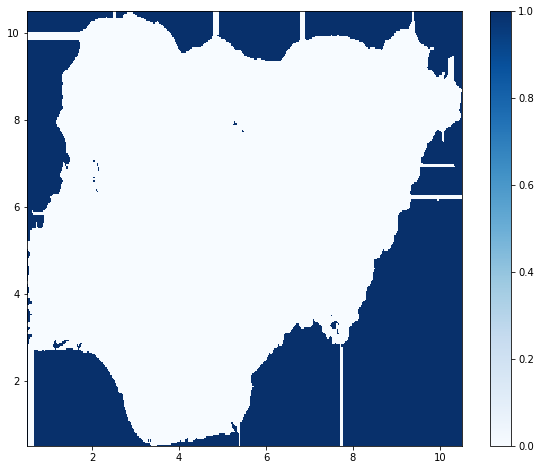

In [38]:
## Creating plot of malaria outbreak 

fig, ax = subplots(figsize=(10, 8))
plt.imshow(m_l, interpolation='nearest', cmap='Blues', extent=(0.5,10.5,0.5,10.5))
plt.colorbar()
plt.savefig('logit.png')

## Conditional Random Fields - A Discrimitive Approach

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics



In [12]:
classifier_X = classification_data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
classifier_Y = classification_data['Endemicity']

X_trainc, X_testc = train_test_split(classifier_X, test_size=0.2, random_state=21)
Y_trainc, Y_testc = train_test_split(classifier_Y, test_size=0.2, random_state=21)

xtrain = X_trainc.values.tolist()
ytrain = Y_trainc.values.tolist()
xtest = X_testc.values.tolist()
ytest = Y_testc.values.tolist()

xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)



NameError: name 'classification_data' is not defined

In [13]:
crf = sklearn_crfsuite.CRF(algorithm = 'lbfgs', c1 = 0.1, c2 = 0.2, max_iterations = 100, all_possible_transitions = True)

In [14]:
crf.fit(xtrain, ytrain)

NameError: name 'xtrain' is not defined

In [15]:
y_pred_crf = crf.predict(xtest)

NameError: name 'xtest' is not defined

In [16]:
metrics.flat_f1_score(ytest, y_pred, average='weighted')

NameError: name 'ytest' is not defined

In [31]:
X.head(10)

,Resistance,Fever_prop,Mosquito_prop,Temp_suitability,Proximity_to_urban,Urban,Annual_mean_temp,Cropland,Precipitation,Vegetation,Annual_temp_range,Water_bodies
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.023529,0.533333,0.003922,0.937255,1.0


In [32]:
X.shape

(120432, 12)

In [33]:
n_nodes = X.shape[1]
n_nodes

12

In [34]:
edges_0 = np.vstack([np.arange(n_nodes - 1), np.arange(1, n_nodes)])
edges_0

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

In [35]:
x = (np.asarray(X.iloc[:,0]), edges_0)   ##list of a list for first??
x

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]))

In [36]:
f_t = X

In [37]:
crf_xtrain = []
cols = []
for i in range(0, f_t.shape[1]):
    for j in range(0, f_t.shape[1]):  #iterating by columns in dataframe
        x = np.asarray(f_t.iloc[:,j])
        cols.append(x)
        if (len(cols) == 12):
            crf_xtrain.append(((np.asarray(cols)),edges_0))  #np.asarray??
            cols = []
  

#np.asarray(X.iloc[0])

In [38]:
len(crf_xtrain[0][0][0])  #make table with 1 row instead of a list 
crf_xtrain[0][0][0]

array([1., 1., 1., ..., 1., 1., 1.])

In [39]:
crf_ytrain = Y
type(crf_ytrain[0])

numpy.float64

In [40]:
#crf_xtrain = [(features_i, np.vstack([np.arange(features_i.shape[1] - 1), np.arange(1, features_i.shape[1])])) for features_i in f_t]

#crf_ytrain = Y

for idx in range(len(crf_ytrain)):
    if (crf_ytrain[idx] >= .5):  
        crf_ytrain[idx] = 1
    else:
        crf_ytrain[idx] = 0



KeyboardInterrupt: 

In [41]:
crf_ytrain = crf_ytrain.astype(int)
u = list(set(crf_ytrain))
u

[0, 1]

In [42]:
crf_ytrain = np.asarray(crf_ytrain)
crf_ytrain


array([1, 1, 1, ..., 1, 1, 1])

In [43]:
crf_ytrain

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
from pystruct.models import GraphCRF
from pystruct.learners import FrankWolfeSSVM

In [45]:
model = GraphCRF(directed = True, inference_method = "max-product")
ssvm = FrankWolfeSSVM(model=model, C=.1, max_iter=10)
ssvm.fit(crf_xtrain, crf_ytrain) 

TypeError: No matching signature found

## NN

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

In [13]:
X = data[['Resistance', 'Fever_prop','Mosquito_prop','Temp_suitability', 'Proximity_to_urban', 'Urban', 'Annual_mean_temp', 'Cropland', 'Precipitation','Vegetation', 'Annual_temp_range', 'Water_bodies']]
Y = data['Endemicity']

X_train, X_test = train_test_split(X, test_size=0.2, random_state=21)
Y_train, Y_test = train_test_split(Y, test_size=0.2, random_state=21)


In [14]:
model = Sequential()
model.add(Dense(12, input_dim=12, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 269
Trainable params: 269
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

Instructions for updating:
Use tf.cast instead.


In [16]:
nn_endemicity = model.fit(X_train, Y_train, epochs=10, batch_size=50,  verbose=1, validation_split=0.2)


Train on 77076 samples, validate on 19269 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
77076/77076 [==============================] - 6s 78us/sample - loss: 0.0313 - mean_squared_error: 0.0313 - mean_absolute_error: 0.1053 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0721
Epoch 2/10
77076/77076 [==============================] - 5s 67us/sample - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.0706 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0722
Epoch 3/10
77076/77076 [==============================] - 6s 72us/sample - loss: 0.0177 - mean_squared_error: 0.0177 - mean_absolute_error: 0.0697 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0706
Epoch 4/10
77076/77076 [==============================] - 5s 64us/sample - loss: 0.0173 - mean_squared_error: 0.0173 - mean_absolute_error: 0.0685 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - va

In [22]:
ynew = model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(Y_test, ynew)

0.06517304629852239